# Daily Electricity Load Forecasting in Sri Lanka

### Introduction
This project forecasts daily electricity demand in Sri Lanka to support energy planning
and minimize risk of power shortages. The dataset consists of high-frequency load and
weather information at 15-minute intervals, which is aggregated to daily values for
modeling. Facebook Prophet is used as the main forecasting model, and SHAP analysis
is applied for model explainability.


- Dataset: Synthetic Sri Lankan load forecasting dataset
- Goal: Forecast daily electricity demand for the next 30 days
- Model: Facebook Prophet

## Step 1: Setup and Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")  # Stylying method of matplotlib

# Function of MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


## Step 2: Load and Inspect Data

We load your dataset and parse the Timestamp column to datetime objects

In [22]:
# Load the dataset
df = pd.read_csv("forecasting_dataset.csv")

# Convert Timestamp to datetime objects
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Set the Timestamp as the index
df = df.set_index("Timestamp")

# Inspect the first few rows
df.head()


,Temperature (°C),Humidity (%),Wind Speed (m/s),Rainfall (mm),Solar Irradiance (W/m²),GDP (LKR),Per Capita Energy Use (kWh),Electricity Price (LKR/kWh),Day of Week,Hour of Day,Month,Season,Public Event,Load Demand (kW)
Timestamp,,,,,,,,,,,,,,
2020-01-01 00:00:00,28.993428,75.011269,1.053861,4.140513,185.892561,925.621430,502.915605,20.454440,2,0,1,Summer,0,1599.342831
2020-01-01 00:15:00,27.723471,77.024015,1.085152,9.446997,281.782650,1020.823521,497.286366,27.776449,2,0,1,Summer,0,1472.347140
2020-01-01 00:30:00,29.295377,74.732958,3.363800,4.265813,328.942058,1028.847455,488.816292,21.097420,2,0,1,Summer,0,1629.537708
2020-01-01 00:45:00,31.046060,87.615995,2.539148,1.038103,336.407064,937.963002,468.038834,26.032137,2,0,1,Summer,1,1804.605971
2020-01-01 01:00:00,27.531693,79.709858,1.366819,4.201393,205.494256,934.477462,488.565716,27.079114,2,1,1,Summer,0,1453.169325


## Step 3: Preprocessing (Resampling to Daily)

Project title is "Daily Electricity Load Forecasting", but the data is in 15-minute intervals. So I aggregate this to a Daily frequency. I will take the mean "Load demand" for each day.

            Daily_Load_kW
Timestamp                
2020-01-01    1477.682597
2020-01-02    1510.096253
2020-01-03    1505.563921
2020-01-04    1518.027496
2020-01-05    1505.253266


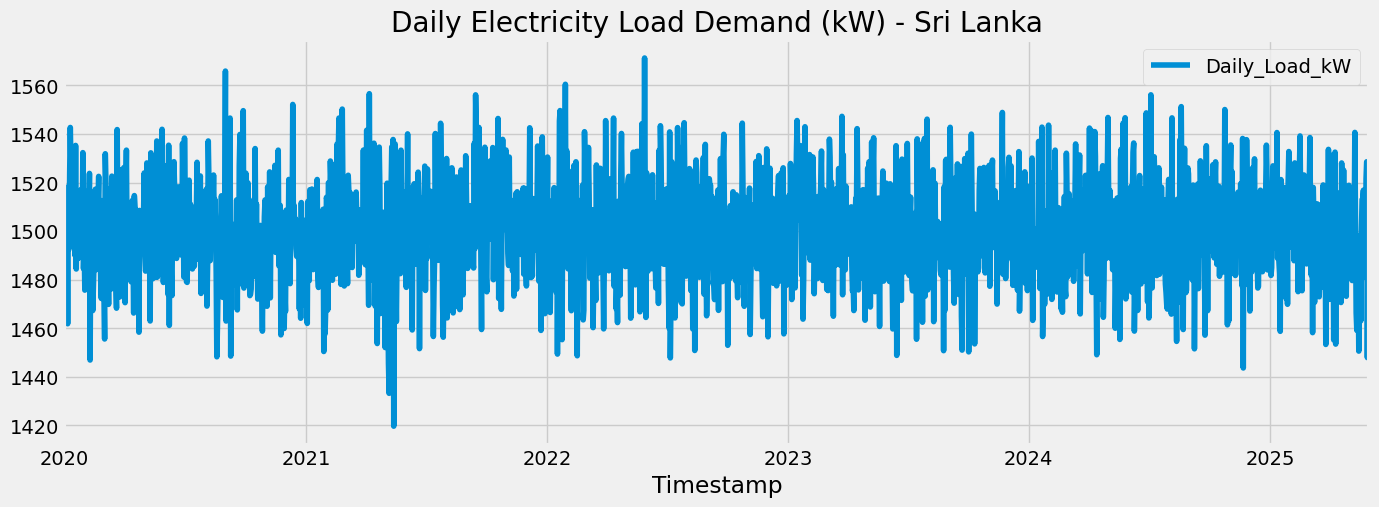

In [23]:
# Resample to Daily frequency ('D') and take the mean of Load Demand
daily_df = df[["Load Demand (kW)"]].resample("D").mean()

# Rename the column for clarity
daily_df.columns = ["Daily_Load_kW"]

# Check the new daily data
print(daily_df.head())

# Plot the daily load
daily_df.plot(
    style="-", figsize=(15, 5), title="Daily Electricity Load Demand (kW) - Sri Lanka"
)
plt.show()


## Step 4: Train / Test Split

Split the data chronologically. 
Since the data starts in 01-01-2020 and goes to 31-05-2025, we will use 01-01-2024 as the split point (Train on 2020-2023, Test on 2024-2025).

Total data points: 1978
Split point : 1582
Split date: 2024-05-01 00:00:00


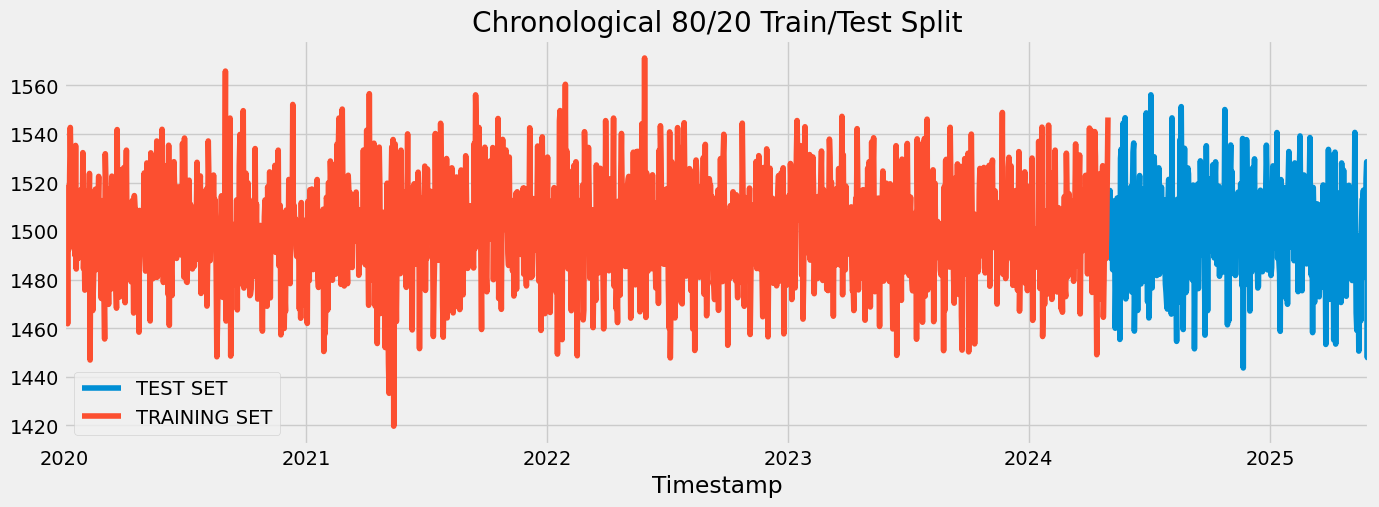


Training set size: 1582 (79.98%)
Test set size: 396 (20.02%)


In [24]:
# 1. Determine the split point
split_index = int(len(daily_df) * 0.8)

# 2. Get the date corresponding to that index
split_date = daily_df.index[split_index]

print(f"Total data points: {len(daily_df)}")
print(f"Split point : {split_index}")
print(f"Split date: {split_date}")

# 3. Create Train and Test sets
train = daily_df.loc[daily_df.index < split_date].copy()
test = daily_df.loc[daily_df.index >= split_date].copy()

# 4. Visualize the split
test.rename(columns={"Daily_Load_kW": "TEST SET"}).join(
train.rename(columns={"Daily_Load_kW": "TRAINING SET"}), how="outer"
).plot(figsize=(15, 5), title="Chronological 80/20 Train/Test Split", style="-")
plt.show()

# Verification (Optional)
print(f"\nTraining set size: {len(train)} ({len(train) / len(daily_df):.2%})")
print(f"Test set size: {len(test)} ({len(test) / len(daily_df):.2%})")

## Step 5: Prepare Data for Prophet

Prophet requires the columns to be named exactly ds (Date Stamp) and y (Target).

In [25]:
# Reset index to make 'Timestamp' a column again
train_prophet = train.reset_index().rename(columns={'Timestamp': 'ds', 'Daily_Load_kW': 'y'})
test_prophet = test.reset_index().rename(columns={'Timestamp': 'ds', 'Daily_Load_kW': 'y'})

train_prophet.head()

,ds,y
0,2020-01-01,1477.682597
1,2020-01-02,1510.096253
2,2020-01-03,1505.563921
3,2020-01-04,1518.027496
4,2020-01-05,1505.253266


## Step 6: Train the Model

In [26]:
# Initialize the model
model = Prophet()

# Fit the model to the training data
model.fit(train_prophet)


15:48:44 - cmdstanpy - INFO - Chain [1] start processing
15:48:44 - cmdstanpy - INFO - Chain [1] done processing
15:48:44 - cmdstanpy - INFO - Chain [1] done processing


## Step 7: Make Predictions

In [27]:
# Make predictions on the test set
forecast = model.predict(test_prophet)

# Inspect the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2024-05-01,1500.050060,1475.554062,1526.700241
1,2024-05-02,1501.170703,1474.546172,1526.826716
2,2024-05-03,1501.695486,1476.423549,1527.154489
3,2024-05-04,1501.579490,1475.532825,1525.680573
4,2024-05-05,1501.918136,1476.193512,1527.578819


## Step 8: Visualize Forecast vs. Actuals

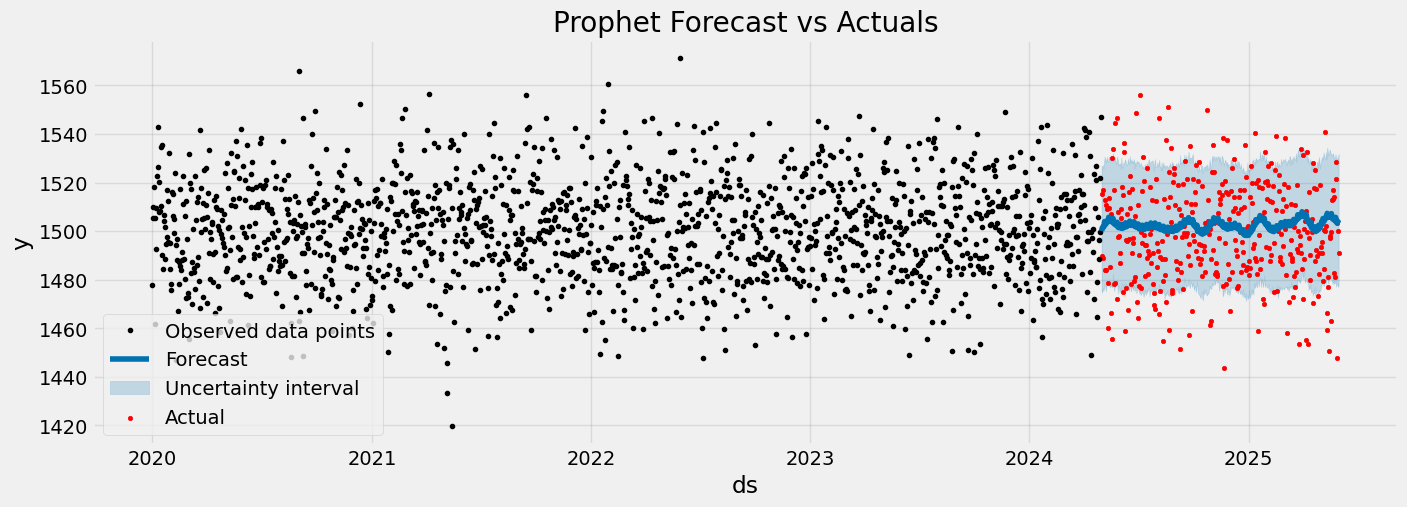

In [28]:
# Plot the forecast
fig, ax = plt.subplots(figsize=(15, 5))
model.plot(forecast, ax=ax)
ax.scatter(test.index, test["Daily_Load_kW"], color="r", s=10, label="Actual")
ax.set_title("Prophet Forecast vs Actuals")
ax.legend()
plt.show()


## Step 9: Analyze Components

This shows the trend, weekly seasonality, and yearly seasonality patterns.

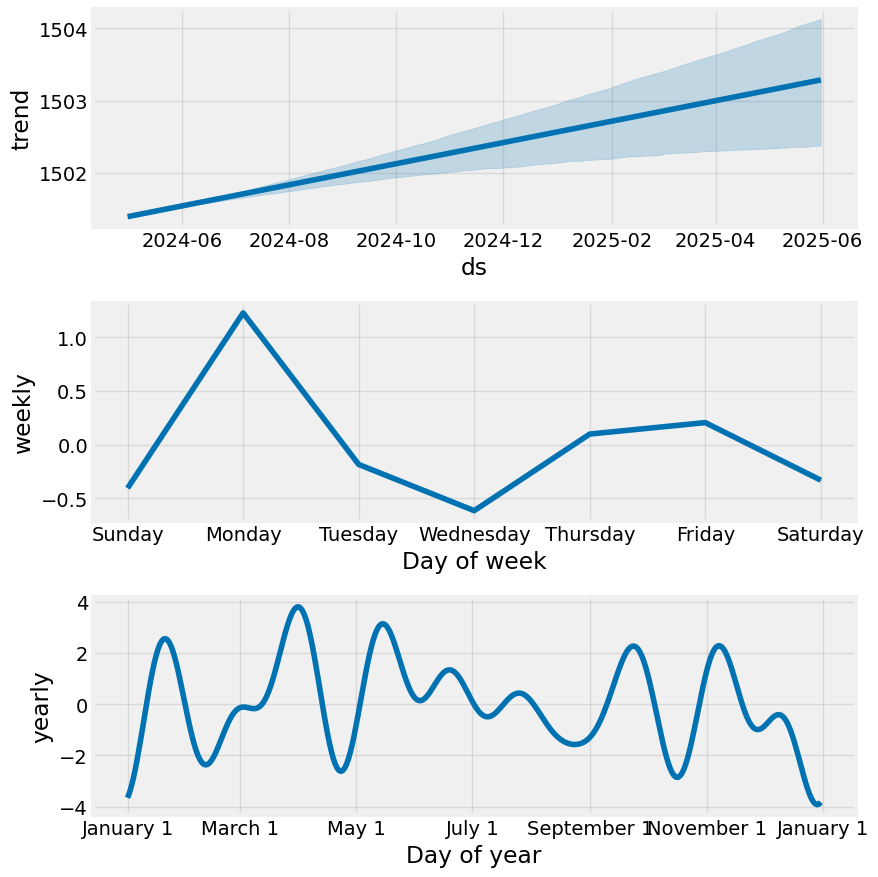

In [29]:
fig = model.plot_components(forecast)
plt.show()


## Step 10: Evaluation Metrics

In [30]:
rmse = np.sqrt(mean_squared_error(test['Daily_Load_kW'], forecast['yhat']))
mae = mean_absolute_error(test['Daily_Load_kW'], forecast['yhat'])
mape = mean_absolute_percentage_error(test['Daily_Load_kW'], forecast['yhat'])

print(f'RMSE: {rmse:.2f}')
print(f'MAE:  {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 20.96
MAE:  16.84
MAPE: 1.13%


## Step 11. Predict the Future Month

In [40]:
#Configuration for 1 month
periods_to_forecast = 30
frequency = 'D' # 'D' = Daily

# 1. Create the future dataframe
future = model.make_future_dataframe(
    periods=periods_to_forecast, 
    freq=frequency, 
    include_history=False
)

print(f"Future dataframe created with {len(future)} entries (1 month).")

# 2. Make the prediction
forecast = model.predict(future)

# 3. Display the predictions for the upcoming month
print("\nForecasted Daily Load (kW) for the next 30 days:\n")

# The 'ds' =  date, 'yhat' = predicted load.
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


Future dataframe created with 30 entries (1 month).

Forecasted Daily Load (kW) for the next 30 days:

          ds         yhat   yhat_lower   yhat_upper
0 2024-05-01  1500.050060  1474.719816  1527.531847
1 2024-05-02  1501.170703  1473.816822  1527.265343
2 2024-05-03  1501.695486  1474.125306  1525.757780
3 2024-05-04  1501.579490  1476.068187  1528.575890
4 2024-05-05  1501.918136  1476.497158  1527.977692


## Step 12: SHAP Analysis

In [32]:
import shap

### 12.1 Prepare Feature Data

Prophet internally generates features (trend, seasonality components). Need to prepare data for SHAP analysis.

In [33]:
# Create training feature dataframe with 'ds' column
X_train = train.reset_index().rename(columns={'Timestamp': 'ds'})

# Define a wrapper prediction function for SHAP
def prophet_predict_wrapper(ds_df):

    # Wrapper function to make Prophet compatible with SHAP.
    # Accepts dates and returns predictions.
    # Ensure the input is a DataFrame.
    
    if isinstance(ds_df, np.ndarray):
        # Convert back to DataFrame if SHAP passes an array
        ds_df = pd.DataFrame(ds_df, columns=['ds'])
        ds_df['ds'] = pd.to_datetime(ds_df['ds'])
    
    # Call the Prophet model's predict method
    forecast = model.predict(ds_df)
    
    # Return the prediction values as 1D array
    return forecast['yhat'].values.reshape(-1)


### 12.2 Initialize SHAP KernelExplainer

We use "KernelExplainer" to explain the Prophet model's predictions by analyzing feature contributions.

In [34]:
# Sample 100 random dates from training set as background data
# This speeds up computation while maintaining data distribution
background_data = X_train[['ds']].sample(n=100, random_state=42).copy()

# Initialize the Kernel Explainer
explainer = shap.KernelExplainer(
    model=prophet_predict_wrapper,
    data=background_data.values,
    feature_names=['ds']
)

print(f"Kernel Explainer initialized with {len(background_data)} background samples.")

Kernel Explainer initialized with 100 background samples.


### 12.3 Calculate SHAP Values

Calculate SHAP values for test set samples.

In [ ]:
# Prepare test data
X_test = test.reset_index().rename(columns={'Timestamp': 'ds'})
X_test_sample = X_test[['ds']].sample(n=50, random_state=42).copy()  # sample size = 50 dates

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_sample.values)

print(f"SHAP values calculated!\nSHAP values shape: {shap_values.shape}")

100%|██████████| 50/50 [00:01<00:00, 39.25it/s]

SHAP values calculated!
SHAP values shape: (50, 1)


### 12.4 Extract Prophet Components for Visualization

In [36]:
forecast_components = model.predict(X_test_sample)

# Identify all relevant component columns (features that affect yhat)
# Exclude date, prediction, and confidence intervals
feature_cols = [col for col in forecast_components.columns 
                if col not in ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 
                              'trend_lower', 'trend_upper']]

# Create feature matrix from Prophet components
X_component_features = forecast_components[feature_cols]

# Calculate expected value (baseline)
expected_value = forecast_components['trend'].mean()

print(f"Extracted {len(feature_cols)} Prophet components as:")
print(f"  {', '.join(feature_cols)}")
print(f"Expected value (baseline): {expected_value:.2f} kW")

Extracted 13 Prophet components as:
  trend, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper
Expected value (baseline): 1502.28 kW


### 12.5 SHAP Summary Plot

- Visualize the impact of Prophet components on predictions. 
- Shows which components have the largest influence on changing the predicted load.

**Summary Plot**: 
   - Features at the top have the largest impact on predictions
   - Red = high feature value, Blue = low feature value
   - Horizontal position shows impact direction (positive/negative)

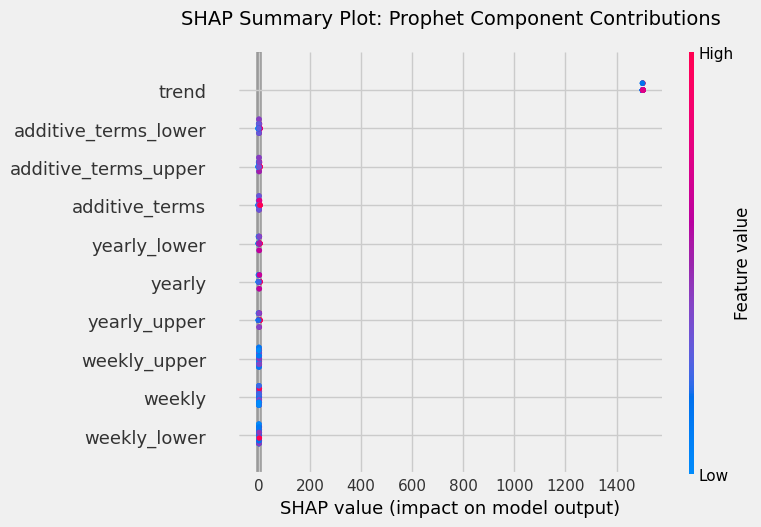

In [37]:
plt.figure(figsize=(10, 6))

shap.summary_plot(
    shap_values=X_component_features.values,
    features=X_component_features,
    feature_names=feature_cols,
    max_display=10,  # Display top 10 contributing components
    show=False
)

plt.title("SHAP Summary Plot: Prophet Component Contributions", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


Interpretation
- Features at the top have the largest impact on predictions.
- Red dots = high feature values, Blue dots = low feature values.
- Position on x-axis shows impact direction.

- The "trend" component has the largest SHAP values (up to $\approx 1400$), showing it's the most important factor in the model's predictions.
- All seasonal components have SHAP values clustered tightly around zero. (between $\approx -50$ and $\approx +50$). This means the weekly and yearly seasonality terms are having almost no measurable impact on the final predicted load compared to the trend.

### 12.6 SHAP Feature Importance Bar Plot

Shows the mean absolute SHAP value for each component, indicating overall feature importance.

**Feature Importance Bar Plot**:
   - Shows average absolute impact of each component
   - Higher bars = more important for predictions

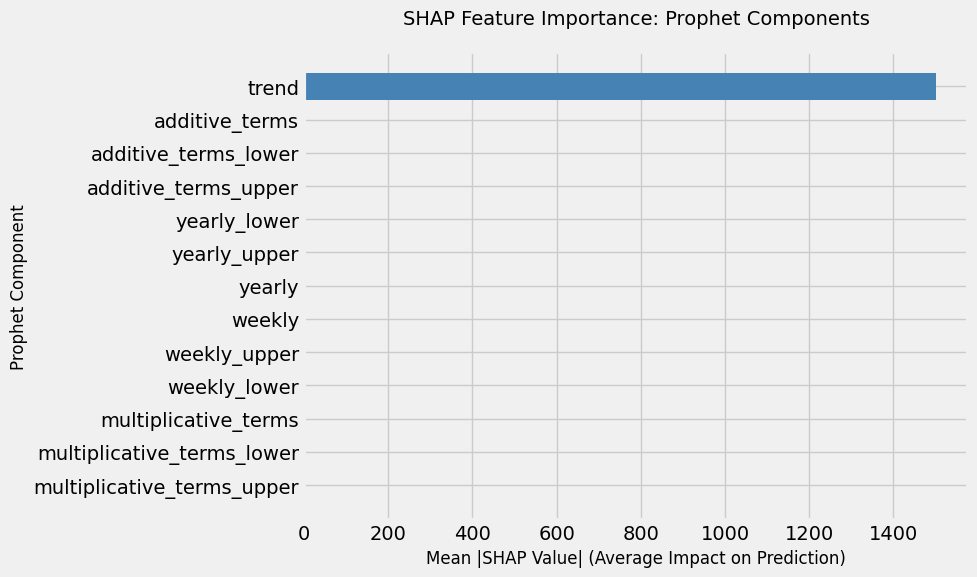


Top 5 Most Important Components:
              Component  Mean_Abs_SHAP
0                 trend    1502.282992
1        additive_terms       1.320914
2  additive_terms_lower       1.320914
3  additive_terms_upper       1.320914
8          yearly_lower       1.267060


In [38]:
# Calculate mean absolute SHAP values for each feature
shap_importance = pd.DataFrame({
    'Component': feature_cols,
    'Mean_Abs_SHAP': np.abs(X_component_features.values).mean(axis=0)
}).sort_values('Mean_Abs_SHAP', ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
plt.barh(shap_importance['Component'], shap_importance['Mean_Abs_SHAP'], color='steelblue')
plt.xlabel('Mean |SHAP Value| (Average Impact on Prediction)', fontsize=12)
plt.ylabel('Prophet Component', fontsize=12)
plt.title('SHAP Feature Importance: Prophet Components', fontsize=14, pad=20)
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Components:")
print(shap_importance.head())

### 12.9 Interpretation and Key Insights

**Example Interpretation:**
- If **yearly seasonality** has high SHAP values (red dots on right), it means periods of high annual demand (e.g., summer) strongly increase predicted load.
- If **trend** dominates the importance bar plot, the long-term demand pattern is the strongest driver.